# Global Base Line Approach with Item To Item Collaborative Filtering


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.cluster as clu
from sklearn import neighbors as nei
from sklearn import metrics as met

In [9]:
df = pd.read_csv("train.csv")
df.head()

,userID,movieID,rating
0,4490,2109,4
1,5839,3471,4
2,5382,150,3
3,1262,1237,5
4,6005,2273,4


In [35]:
train_size = round(df.shape[0]*0.999)
test_size = df.shape[0] - round(df.shape[0]*0.999) 
print("train size", train_size)
print("test size", test_size)

train_df = df[:train_size]
print(train_df.shape)
test = df[train_size:]
print(test.shape)

train size 989219
test size 990
(989219, 3)
(990, 3)


In [38]:
global_mean = train_df.rating.mean()
global_mean

3.581504196745109

In [103]:
test = df[train_size:]
test.head()

,userID,movieID,rating
989219,5847,344,4
989220,5626,3527,3
989221,2798,1544,3
989222,4969,1617,5
989223,4672,3175,5


In [7]:
U = train_df.pivot("movieID","userID","rating")
U.head()

userID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,4.0,NaN,4.0,NaN,NaN,NaN,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train = U.copy()

In [104]:
rmse = [ ]
numbernn = [3,5,7,10,30,50
            ,]
for numn in numbernn:
    print("="*50)
    myPreds = []
    realLabels = []
    t = 0
    for i in test.index:
        k = numn
        movieId = test.movieID[i] 
        userId  = test.userID[i]

        #GLOBAL BASE LINE ESTIMATOR
        user_bias = train.dropna(subset=[userId],axis=0).loc[:,userId].mean() - global_mean
        movie_bias = train.dropna(subset=[movieId],axis=1).loc[movieId,:].mean() - global_mean
        global_base_line = global_mean + user_bias + movie_bias

        #COLLABORATIVE FILTERING
        filtered_train = train.dropna(subset=[userId])
        filtered_train = filtered_train - filtered_train.mean(axis=1).values.reshape(-1,1)
        filtered_train.fillna(0, inplace=True)

        if k >= len(filtered_train):
            k = len(filtered_train)

        nn = nei.NearestNeighbors(n_neighbors=k,metric="correlation")
        nn.fit(filtered_train)
        
        test_row = U.loc[movieId:movieId, :]
        test_row = test_row - test_row.mean(axis=1).values.reshape(-1,1)
        test_row.fillna(0, inplace=True)

        indices = nn.kneighbors(test_row, return_distance=False)[0]
        similarities = nn.kneighbors(test_row, return_distance=True)[1]

        movieIds = filtered_train.iloc[indices, :].index
        pred = global_base_line  +  ((np.array(train.loc[movieIds,userId].values) - global_base_line ) * similarities ).sum() / (np.array(similarities)).sum()
        if pred > 5:
            pred = 5
        if pred < 1:
            pred = 1  
            
        myPreds.append(pred)
        real_label = test.rating[i]
        print("mov:",movieId,"usr:",userId,"mvBias:",movie_bias, "usr_bias:",user_bias,"globalBL:",global_base_line,"actual:",real_label,"pred:",pred)
        realLabels.append(real_label)
    print(met.mean_squared_error(realLabels, myPreds, squared=False))
    rmse.append(met.mean_squared_error(realLabels, myPreds, squared=False))
    print("="*50)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
mov: 1281 usr: 4891 mvBias: 0.4753678411695832 usr_bias: -0.9924949088194124 globalBL: 3.0643771290952797 actual: 4 pred: 5.0
mov: 1991 usr: 4741 mvBias: -0.8806494958904079 usr_bias: -0.11808956259876746 globalBL: 2.5827651382559336 actual: 5 pred: 3.5945945945945947
mov: 3034 usr: 4614 mvBias: 0.161858635113298 usr_bias: 0.0675024257714476 globalBL: 3.8108652576298545 actual: 3 pred: 4.205479452054795
mov: 3471 usr: 5354 mvBias: 0.43103062219639554 usr_bias: -0.10546585808696207 globalBL: 3.9070689608545424 actual: 5 pred: 4.0
mov: 3681 usr: 1309 mvBias: 0.3393818792042582 usr_bias: 0.11376207544424011 globalBL: 4.034648151393608 actual: 4 pred: 3.5767761650114593
mov: 1294 usr: 4818 mvBias: 0.5495682138873388 usr_bias: 0.34263373428937394 globalBL: 4.473706144921822 actual: 4 pred: 3.4011976047904193
mov: 1542 usr: 1400 mvBias: -0.04304265828357057 usr_bias: 0.44413682889591666 globalBL: 3.982598367357455 actual: 4 pred: 4.7058823529411

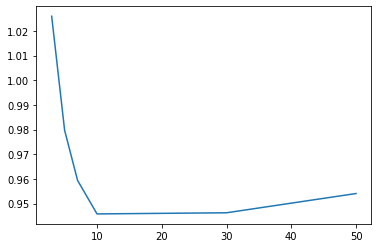

In [105]:
plt.plot(numbernn,rmse);

In [107]:
test = pd.read_csv("test_without_labels.csv",sep="_",names=["userID","movieID"])[1:]
train = U.copy()
test.head(5)


,userID,movieID
1,629,2683.0
2,601,904.0
3,5673,3717.0
4,5616,1721.0
5,1099,3697.0


In [108]:
myPreds = []
realLabels = []
movieIds = []
userIds = []
user_and_movieID = []
t = 0
for i in test.index:
    k = 20
    movieId = int(test.movieID[i] )
    userId  = int(test.userID[i] )
    user_and_movieID.append(str(userId) + "_" + str(movieId))

    #GLOBAL BASE LINE ESTIMATOR
    user_bias = train.dropna(subset=[userId],axis=0).loc[:,userId].mean() - global_mean
    movie_bias = train.dropna(subset=[movieId],axis=1).loc[movieId,:].mean() - global_mean
    global_base_line = global_mean + user_bias + movie_bias


    filtered_train = train.dropna(subset=[userId])
    filtered_train = filtered_train - filtered_train.mean(axis=1).values.reshape(-1,1)
    filtered_train.fillna(0, inplace=True)
    if k >= len(filtered_train):
        k = len(filtered_train)
        
    nn = nei.NearestNeighbors(n_neighbors=k,metric="correlation")
    nn.fit(filtered_train)

    test_row = U.loc[movieId:movieId, :]
    test_row = test_row - test_row.mean(axis=1).values.reshape(-1,1)
    test_row.fillna(0, inplace=True)

    indices = nn.kneighbors(test_row, return_distance=False)[0]
    similarities = nn.kneighbors(test_row, return_distance=True)[1]

    movieIds = filtered_train.iloc[indices, :].index
    pred = global_base_line  +  ((np.array(train.loc[movieIds,userId].values) - global_base_line ) * similarities ).sum() / (np.array(similarities)).sum()

    if pred > 5:
        pred == 5
    if pred < 1:
        pred = 1  
    myPreds.append(pred)

    t += 1
    if t % 500 == 0:
        print(t)
        

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [109]:
pd.DataFrame( { "IDs": user_and_movieID,
                "rating" : myPreds}).to_csv("submission5.csv",index=False) # RMSE = 0.89795

In [110]:
myPreds = []
realLabels = []
user_and_movieID = []
t = 0
for i in test.index:
    k = 10
    movieId = int(test.movieID[i] )
    userId  = int(test.userID[i] )
    user_and_movieID.append(str(userId) + "_" + str(movieId))

    #GLOBAL BASE LINE ESTIMATOR
    user_bias = train.dropna(subset=[userId],axis=0).loc[:,userId].mean() - global_mean
    movie_bias = train.dropna(subset=[movieId],axis=1).loc[movieId,:].mean() - global_mean
    global_base_line = global_mean + user_bias + movie_bias


    filtered_train = train.dropna(subset=[userId])
    filtered_train = filtered_train - filtered_train.mean(axis=1).values.reshape(-1,1)
    filtered_train.fillna(0, inplace=True)
    if k >= len(filtered_train):
        k = len(filtered_train)
        
    nn = nei.NearestNeighbors(n_neighbors=k,metric="correlation")
    nn.fit(filtered_train)

    test_row = U.loc[movieId:movieId, :]
    test_row = test_row - test_row.mean(axis=1).values.reshape(-1,1)
    test_row.fillna(0, inplace=True)

    indices = nn.kneighbors(test_row, return_distance=False)[0]
    similarities = nn.kneighbors(test_row, return_distance=True)[1]

    movieIds = filtered_train.iloc[indices, :].index
    pred = global_base_line  +  ((np.array(train.loc[movieIds,userId].values) - global_base_line ) * similarities ).sum() / (np.array(similarities)).sum()

    if pred > 5:
        pred == 5
    if pred < 1:
        pred = 1  
    myPreds.append(pred)

    t += 1
    if t % 500 == 0:
        print(t)
        

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [111]:
pd.DataFrame( { "IDs": user_and_movieID,
                "rating" : myPreds}).to_csv("submission6.csv",index=False) # RMSE = 0.0.90428